### Description: This is the second data processing and exploration code to generate the overall combined dataset containing only Jakarta districts without Kepulauan Seribu. It contains codes to filter out irrelevant West Java districts n Kepulauan Seribu, as well as generate KDE and histogram plots (Figures 1&2). This script also contains codes to display province-level dengue prevalence estimates and cases for each year (Table 1)

### Libraries

In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

### Data filtering to get jakarta data only

In [32]:
## Read in data
prov = gpd.read_file("../data/processed/low_res_sim.shp")  # Change path if needed
dist = gpd.read_file("../data/processed/high_res_sim.shp")

In [33]:
# get the unique district names
unique_districts = dist["District"].unique()
print(unique_districts)
jkt = ['KOTA JAKARTA BARAT',
 'KOTA JAKARTA PUSAT', 'KOTA JAKARTA SELATAN', 'KOTA JAKARTA TIMUR',
 'KOTA JAKARTA UTARA']

['BANDUNG' 'BANDUNG BARAT' 'BEKASI' 'BOGOR' 'CIAMIS' 'CIANJUR' 'CIREBON'
 'GARUT' 'INDRAMAYU' 'KARAWANG' 'KOTA BANDUNG' 'KOTA BANJAR' 'KOTA BEKASI'
 'KOTA BOGOR' 'KOTA CIMAHI' 'KOTA CIREBON' 'KOTA DEPOK'
 'KOTA JAKARTA BARAT' 'KOTA JAKARTA PUSAT' 'KOTA JAKARTA SELATAN'
 'KOTA JAKARTA TIMUR' 'KOTA JAKARTA UTARA' 'KOTA SUKABUMI'
 'KOTA TASIKMALAYA' 'KUNINGAN' 'MAJALENGKA' 'PANGANDARAN' 'PURWAKARTA'
 'SUBANG' 'SUKABUMI' 'SUMEDANG' 'TASIKMALAYA']


In [34]:
#filter df_combined to only retain observations in district = jkt list
jkt_dist = dist[dist["District"].isin(jkt)]

#filter for jkt_prov data
jkt_prov = prov[prov["Province"] == "DKI Jakarta"]

In [35]:
#print head
jkt_dist.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,geometry
68,KOTA JAKARTA BARAT,2020,124.44,0.8138,DKI Jakarta,161,184826,1.485262,0.951917,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
69,KOTA JAKARTA BARAT,2021,124.44,0.8176,DKI Jakarta,138,183270,1.472758,0.951917,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
70,KOTA JAKARTA BARAT,2022,125.00,0.8251,DKI Jakarta,420,181715,1.453720,0.951917,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
71,KOTA JAKARTA BARAT,2023,125.00,0.8302,DKI Jakarta,359,180159,1.441272,0.951917,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
72,KOTA JAKARTA PUSAT,2020,52.38,0.8139,DKI Jakarta,127,73140,1.396334,0.993514,"POLYGON ((106.83247 -6.14138, 106.83282 -6.141..."


In [36]:
# save as jkt combined divisions so next time dont need to filter again
jkt_dist.to_file("../data/processed/jkt_dist.shp")
jkt_prov.to_file("../data/processed/jkt_prov.shp")

## Check yearly province-level dengue cases and prevalence to reproduce Table 1 values

In [42]:
jkt_prov['incidence'] = (jkt_prov.Cases / jkt_prov.Population)
print("Dengue incidence by province and year (low resolution):")
print(jkt_prov.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')
print(jkt_prov.groupby(['Province', 'Year'])[['Cases']].sum(), '\n')

Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

                  Cases
Province    Year       
DKI Jakarta 2020   1217
            2021   1048
            2022   2113
            2023   1562 



C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Plot data distribution of DKI Jakarta with and without Kepulauan Seribu 

In [38]:
hi = gpd.read_file("../data/processed/high_res.shp")
lo = gpd.read_file("../data/processed/low_res.shp")

In [39]:
#filter to DKI Jakarta only
hi = hi[hi["Province"] == "DKI Jakarta"]
lo = lo[lo["Province"] == "DKI Jakarta"]

hi_small = hi[hi["District"] != "KEPULAUAN SERIBU"]
lo_small = gpd.read_file("../data/processed/low_res_sim.shp")

lo_small = lo_small[lo_small["Province"] == "DKI Jakarta"]

### Plot the KDE and histogram of all the 3 covariates (Fig 2)

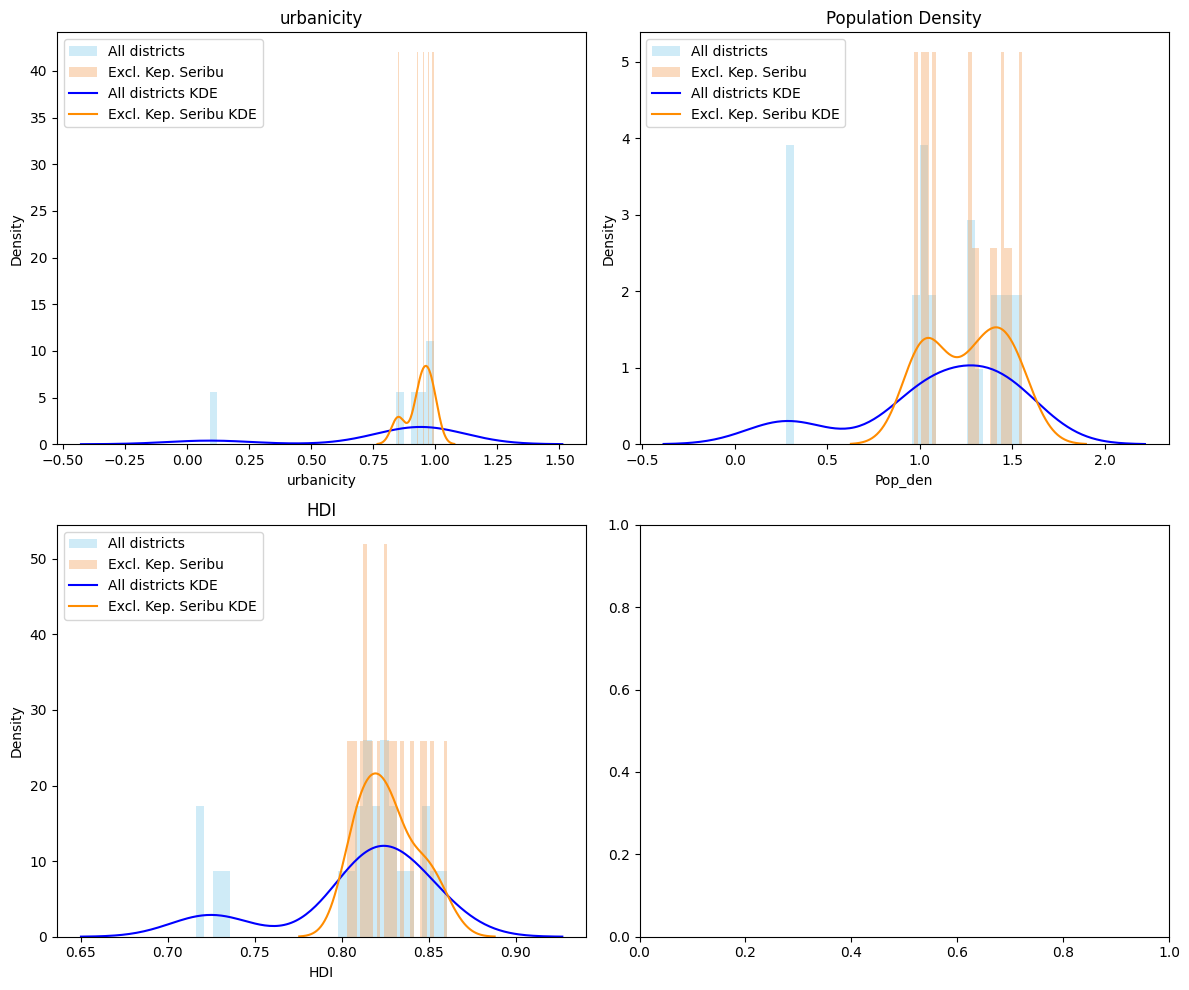

In [40]:
vars_to_plot = ["urbanicity", "Pop_den", "HDI"]
titles      = ["urbanicity", "Population Density", "HDI"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, var, title in zip(axes, vars_to_plot, titles):
    all_vals   = hi[var].dropna().values
    nodki_vals = hi_small[var].dropna().values

    # Plot histograms
    ax.hist(all_vals, bins=30, alpha=0.4, label="All districts", color='skyblue', density=True)
    ax.hist(nodki_vals, bins=30, alpha=0.4, label="Excl. Kep. Seribu", color='sandybrown', density=True)

    # Overlay KDE plots
    sns.kdeplot(all_vals, color='blue', label='All districts KDE', ax=ax)
    sns.kdeplot(nodki_vals, color='darkorange', label='Excl. Kep. Seribu KDE', ax=ax)

    ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

### Plot the KDE of each covariates across all 4 yrs (Fig 1)

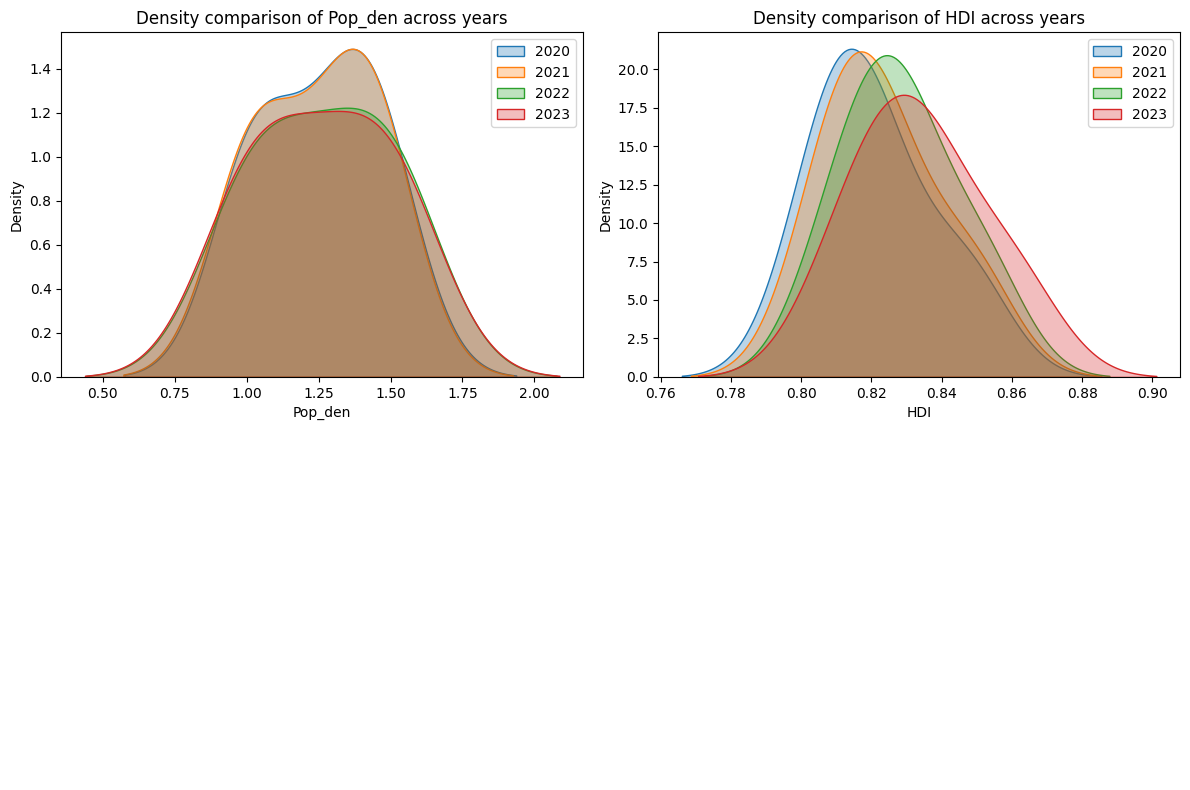

In [41]:
#plot kernel density (visual check)
vars_to_plot = ["Pop_den", "HDI"]

# Pick years you want to compare
years_to_compare = [2020, 2021, 2022, 2023]

# Plotting
plt.figure(figsize=(12, 8))

for i, var in enumerate(vars_to_plot, 1):
    plt.subplot(2, 2, i)  # Create a subplot for each variable (2 rows, 2 columns)
    for year in years_to_compare:
        subset = hi_small[hi_small['Year'] == year]
        sns.kdeplot(subset[var].dropna(), label=f"{year}", fill=True, alpha=0.3)

    plt.title(f"Density comparison of {var} across years")
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.legend()

# Hide the empty subplot (bottom right)
plt.subplot(2, 2, 4).axis('off')

plt.tight_layout()  # Adjust layout for better fit
plt.show()